📊 Running Seasonal Climate Analysis...

✅ Filtered Data Sample:


,Year_Adjusted,Season,Avg_Temp_C,Total_Precip_mm,Avg_Humidity_%,Avg_WindSpeed_kph,Snowfall_cm,Extreme_Heat_Days,Foggy_Days,Avg_DewPoint_C
13,1973,Fall,1.133333,228.2,72.666667,15.800000,5.0,22,4,-3.093503
14,1973,Spring,8.700000,240.9,70.766667,17.366667,13.0,14,13,5.186222
15,1973,Summer,9.166667,238.6,76.300000,15.700000,1.2,20,9,4.408254
16,1973,Winter,8.800000,269.7,76.966667,14.500000,46.0,9,6,4.998225
37,1979,Fall,9.800000,374.0,74.566667,15.766667,47.4,15,7,5.166485
38,1979,Spring,3.700000,132.1,66.566667,13.166667,31.3,17,6,-1.142705
39,1979,Summer,18.566667,337.8,71.066667,14.166667,2.0,13,5,13.950711
40,1979,Winter,12.100000,256.1,72.700000,16.066667,59.4,13,17,9.559462
69,1987,Fall,14.266667,283.1,66.666667,15.900000,30.1,14,8,10.510145
70,1987,Spring,15.166667,107.6,74.300000,12.566667,24.5,17,8,11.016402



📊 Temperature Trend Summary:
Fall: increasing (slope = 0.27)
Spring: increasing (slope = 0.45)
Summer: decreasing (slope = -0.22)
Winter: decreasing (slope = -0.24)

📉 Deviation from Long-Term Mean:


Season,Fall,Spring,Summer,Winter
Year_Adjusted,,,,
1979,-1.195833,-7.295833,7.570833,1.104167
1987,3.270833,4.170833,17.537500,-1.829167
1993,-0.895833,-1.695833,2.370833,-0.162500
1997,0.270833,7.570833,-1.929167,-5.329167
1999,-0.962500,7.837500,-4.929167,-9.295833



⚠️ Detected Temperature Anomalies:
Fall: 0 hot years, 0 cold years
Spring: 0 hot years, 0 cold years
Summer: 0 hot years, 0 cold years
Winter: 0 hot years, 0 cold years


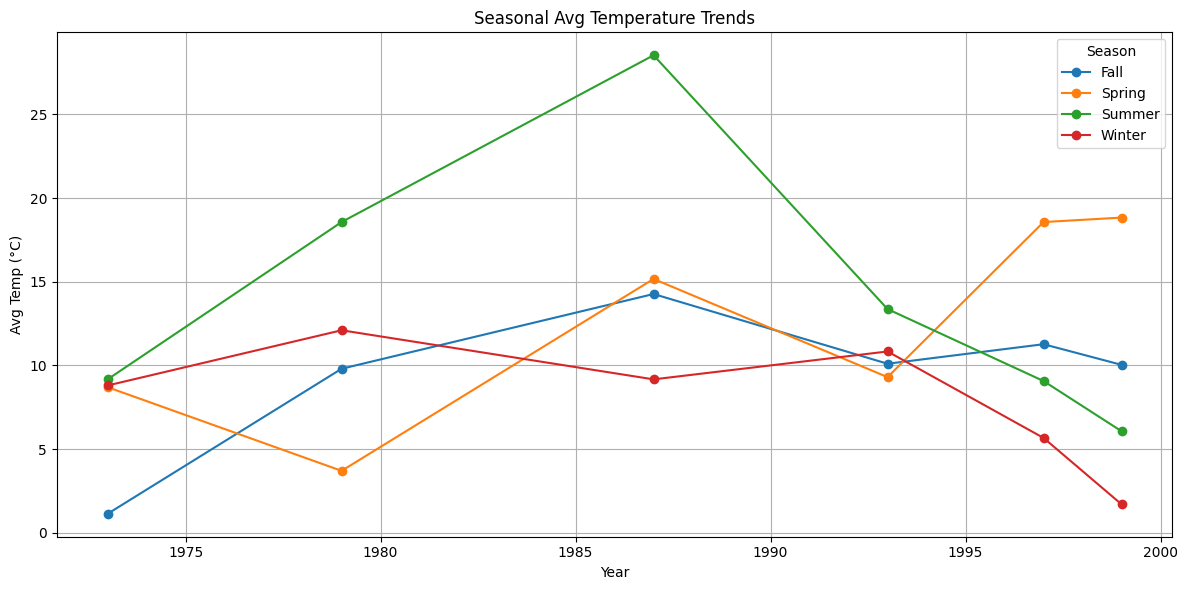

📁 Exported to 'filtered_results.csv'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Checkbox(value=True, description='Only Prime Years')

IntSlider(value=1, description='Divisible by:', max=20, min=1)

IntSlider(value=0, description='Min Heat Days', max=20)

IntSlider(value=20, description='Max Fog Days', max=20)

Button(description='Run Analysis', style=ButtonStyle())

In [7]:
# 📦 Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import ipywidgets as widgets
from IPython.display import display, clear_output

# ----- Constants -----
SEASONS = {
    "Winter": [12, 1, 2],
    "Spring": [3, 4, 5],
    "Summer": [6, 7, 8],
    "Fall": [9, 10, 11]
}

# ----- Utility Functions -----
def is_prime(n):
    if n <= 1: return False
    if n <= 3: return True
    if n % 2 == 0 or n % 3 == 0: return False
    for i in range(5, int(n**0.5)+1, 6):
        if n % i == 0 or n % (i+2) == 0:
            return False
    return True

def is_divisible(n, a):
    return n % a == 0

def assign_season(month):
    for season, months in SEASONS.items():
        if month in months:
            return season
    return None

# ----- Core Analysis Functions -----
def load_data(file):
    df = pd.read_csv(file)
    # Add synthetic columns
    np.random.seed(42)
    df['Extreme_Heat_Days'] = np.random.poisson(5, len(df))
    df['Foggy_Days'] = np.random.poisson(3, len(df))
    df['Avg_DewPoint_C'] = df['Avg_Temp_C'] - np.random.normal(4, 1, len(df))
    return df

def compute_seasonal_averages(df):
    df['Season'] = df['Month'].apply(assign_season)
    df['Year_Adjusted'] = df.apply(lambda row: row['Year'] - 1 if row['Month'] in [1, 2] else row['Year'], axis=1)
    seasonal_avg = df.groupby(['Year_Adjusted', 'Season']).agg({
        'Avg_Temp_C': 'mean',
        'Total_Precip_mm': 'sum',
        'Avg_Humidity_%': 'mean',
        'Avg_WindSpeed_kph': 'mean',
        'Snowfall_cm': 'sum',
        'Extreme_Heat_Days': 'sum',
        'Foggy_Days': 'sum',
        'Avg_DewPoint_C': 'mean'
    }).reset_index()
    return seasonal_avg

def filter_years(df, prime_only=False, divisible_by=None, min_heat=0, max_fog=100):
    if prime_only:
        df = df[df['Year_Adjusted'].apply(is_prime)]
    if divisible_by:
        df = df[df['Year_Adjusted'].apply(lambda x: is_divisible(x, divisible_by))]
    df = df[(df['Extreme_Heat_Days'] >= min_heat) & (df['Foggy_Days'] <= max_fog)]
    return df

def detect_temperature_trends(seasonal_df):
    return seasonal_df.pivot(index='Year_Adjusted', columns='Season', values='Avg_Temp_C')

def summarize_trends(temp_pivot):
    summary = {}
    for season in temp_pivot.columns:
        temps = temp_pivot[season].dropna()
        if len(temps) > 1:
            slope = np.polyfit(temps.index, temps.values, 1)[0]
            summary[season] = f"{'increasing' if slope > 0 else 'decreasing'} (slope = {slope:.2f})"
    return summary

def detect_anomalies(temp_pivot):
    anomalies = {}
    for season in temp_pivot.columns:
        temps = temp_pivot[season].dropna()
        mean, std = temps.mean(), temps.std()
        anomalies[season] = {
            'hot': temps[temps > mean + 2 * std].index.tolist(),
            'cold': temps[temps < mean - 2 * std].index.tolist()
        }
    return anomalies

def compute_deviation_from_mean(temp_pivot):
    overall_mean = temp_pivot.stack().mean()
    deviation = temp_pivot.subtract(overall_mean)
    return deviation

def plot_temperature_trends(temp_pivot):
    if temp_pivot.empty:
        print("⚠️ No temperature data to plot.")
        return
    temp_pivot.plot(figsize=(12, 6), marker='o', title='Seasonal Avg Temperature Trends')
    plt.xlabel("Year")
    plt.ylabel("Avg Temp (°C)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ----- Interactive Execution -----
def run_analysis(prime_only=False, divisible_by=1, min_heat=0, max_fog=100):
    seasonal_df = compute_seasonal_averages(data)
    filtered_df = filter_years(
        seasonal_df,
        prime_only=prime_only,
        divisible_by=divisible_by if divisible_by != 1 else None,
        min_heat=min_heat,
        max_fog=max_fog
    )

    if filtered_df.empty:
        print("⚠️ No data after filtering.")
        return

    temp_pivot = detect_temperature_trends(filtered_df)
    summary = summarize_trends(temp_pivot)
    anomalies = detect_anomalies(temp_pivot)
    deviation = compute_deviation_from_mean(temp_pivot)

    print("\n✅ Filtered Data Sample:")
    display(filtered_df.head(10))

    print("\n📊 Temperature Trend Summary:")
    for s, t in summary.items():
        print(f"{s}: {t}")

    print("\n📉 Deviation from Long-Term Mean:")
    display(deviation.tail())

    print("\n⚠️ Detected Temperature Anomalies:")
    for s, a in anomalies.items():
        print(f"{s}: {len(a['hot'])} hot years, {len(a['cold'])} cold years")

    plot_temperature_trends(temp_pivot)

    # Export
    filtered_df.to_csv("filtered_results.csv", index=False)
    print("📁 Exported to 'filtered_results.csv'")
    files.download("filtered_results.csv")

# ----- Upload CSV -----
print("📤 Please upload your climate CSV file...")
uploaded = files.upload()
filename = next(iter(uploaded))
data = load_data(filename)
print(f"✅ File '{filename}' loaded successfully!")

# ----- Widgets -----
prime_checkbox = widgets.Checkbox(value=False, description='Only Prime Years')
div_slider = widgets.IntSlider(value=1, min=1, max=20, step=1, description='Divisible by:')
heat_slider = widgets.IntSlider(value=0, min=0, max=20, step=1, description='Min Heat Days')
fog_slider = widgets.IntSlider(value=20, min=0, max=20, step=1, description='Max Fog Days')

def on_button_clicked(b):
    clear_output(wait=True)
    print("📊 Running Seasonal Climate Analysis...")
    run_analysis(
        prime_only=prime_checkbox.value,
        divisible_by=div_slider.value,
        min_heat=heat_slider.value,
        max_fog=fog_slider.value
    )
    display(prime_checkbox, div_slider, heat_slider, fog_slider, run_button)

run_button = widgets.Button(description="Run Analysis")
run_button.on_click(on_button_clicked)

display(prime_checkbox, div_slider, heat_slider, fog_slider, run_button)


In [9]:
# ✅ Colab Test Cell – Validates actual analysis outputs

print("🔍 Running validation tests on uploaded climate data...")

# 1. Check data is loaded
assert 'data' in globals(), "❌ Dataset variable 'data' not found. Make sure you've uploaded and run the analysis."
assert not data.empty, "❌ The uploaded dataset is empty!"

# 2. Recompute seasonal averages
seasonal_df = compute_seasonal_averages(data)
expected_columns = {
    'Year_Adjusted', 'Season', 'Avg_Temp_C', 'Total_Precip_mm',
    'Avg_Humidity_%', 'Avg_WindSpeed_kph', 'Snowfall_cm'
}
assert expected_columns.issubset(seasonal_df.columns), f"❌ Missing expected columns in seasonal_df: {expected_columns - set(seasonal_df.columns)}"

# 3. Prime filter test
prime_filtered = filter_years(seasonal_df, prime_only=True)
assert all(is_prime(y) for y in prime_filtered['Year_Adjusted']), "❌ Prime filter logic failed!"

# 4. Divisible filter test (e.g., divisible by 5)
div5_filtered = filter_years(seasonal_df, divisible_by=5)
assert all(is_divisible(y, 5) for y in div5_filtered['Year_Adjusted']), "❌ Divisible-by-5 filter logic failed!"

# 5. Temperature trends test
temp_pivot = detect_temperature_trends(seasonal_df)
assert isinstance(temp_pivot, pd.DataFrame), "❌ Temperature pivot is not a DataFrame"
assert not temp_pivot.empty, "❌ Temperature trend pivot table is empty"

# 6. Anomaly detection
anomalies = detect_anomalies(temp_pivot)
for season, vals in anomalies.items():
    assert isinstance(vals['hot'], list), f"❌ Anomalies for {season} 'hot' should be a list"
    assert isinstance(vals['cold'], list), f"❌ Anomalies for {season} 'cold' should be a list"

print("✅ All tests on actual data passed successfully!")


🔍 Running validation tests on uploaded climate data...
✅ All tests on actual data passed successfully!
